# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных

# Исследовательский анализ данных

In [1]:
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
# инициализируем препроцессор для изображений, непосредственно
# rescale тут делать было не обязательно
train_datagen = ImageDataGenerator(rescale=1./255)
path = '/datasets/faces/'

In [3]:
# подгружаем таблицу
labels = pd.read_csv(path + 'labels.csv')

In [4]:
#генерируем пакет дополненных данных
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [5]:
# посмотрим размер выборки
labels.shape

(7591, 2)

In [6]:
# разделим пакет на признаки и целевой признак
features, target = next(train_gen_flow)

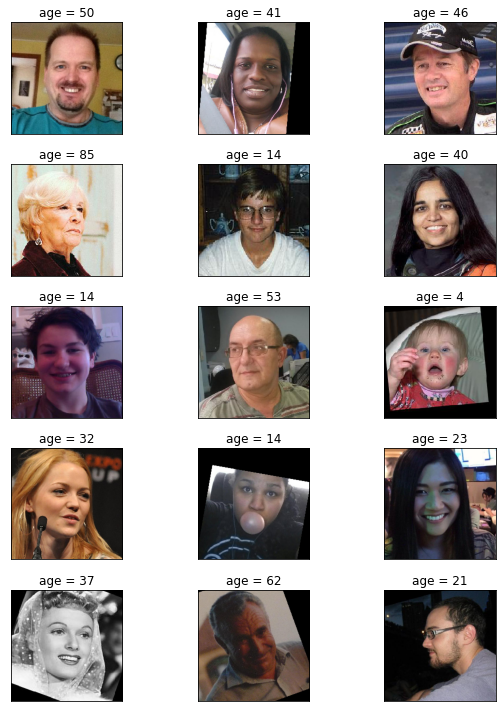

In [7]:
# посмотрим на данные в признаках
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title('age = ' + str(target[i]))
    
    plt.tight_layout()

<AxesSubplot:xlabel='age', ylabel='count'>

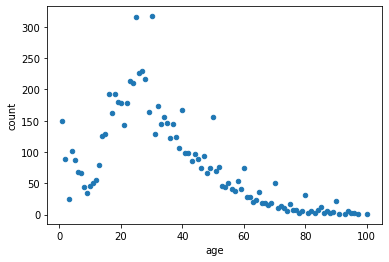

In [8]:
ages = labels['real_age'].value_counts().to_frame()
ages = ages.reset_index()
ages = ages.rename(columns = {'index' : 'age', 'real_age' : 'count'})
ages.plot(kind='scatter', y='count', x='age')

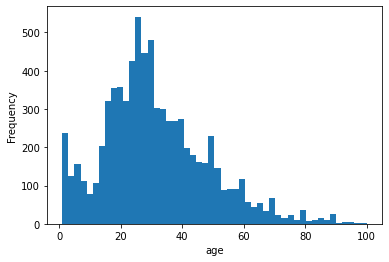

In [9]:
labels['real_age'].plot(kind='hist', bins=50)
plt.xlabel('age')
plt.show()

In [10]:
ages.sort_values(by='count', ascending=False).head(10)

,age,count
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217
5,23,213
6,24,211
7,18,193
8,16,193
9,19,180


<b> Вывод по исследовательскому анализу данных: </b>
    
Датасэт состоит из 7591 изображения, проименнованных через `file_name`. Каждому `file_name` соответствует значение `real_age`. С точки зрения обучения модели присутствует дисбалланс классов: т.к. наиболее распространены фотографии людей, чей возраст находится в диапазоне 15-50 лет.

Среди фотографий встречаются повёрнутые, чёрно-белые, фотографии разных размеров и различные комбинации этих особенностей. Что касается ориентации, в целом изображения повёрнуты незначительно, но если их предварительно нормализовать по положению головы, вероятно, модель станет предсказывать точнее. По положению головы встречаются фотографии в фас, профиль и анфас, что тоже, вероятней всего, скажется на итоговой метрике.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=16, 
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

 
def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
    
    
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=12,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/12
2022-07-05 21:32:57.845338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-05 21:32:58.164319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 71s - loss: 206.1111 - mae: 10.9201 - val_loss: 328.4041 - val_mae: 13.4464
Epoch 2/12
356/356 - 40s - loss: 139.5991 - mae: 9.0074 - val_loss: 181.4360 - val_mae: 10.7126
Epoch 3/12
356/356 - 40s - loss: 113.5378 - mae: 8.1781 - val_loss: 162.9292 - val_mae: 9.5718
Epoch 4/12
356/356 - 39s - loss: 90.3234 - mae: 7.2897 - val_loss: 188.4691 - val_mae: 10.6542
Epoch 5/12
356/356 - 39s - loss: 79.3150 - mae: 6.8070 - val_loss: 176.3968 - val_mae: 9.7914
Epoch 6/12
356/356 - 39s - loss: 66.6458 - mae: 6.2937 - val_loss: 107.1971 - val_mae: 7.6393
Epoch 7/12
356/356 - 39s - loss: 54.6350 - mae: 5.6496 - val_loss: 131.2340 - val_mae: 8.8088
Epoch 8/12
356/356 - 39s - loss: 47.2977 - mae: 5.3018 - val_loss: 105.4931 - val_mae: 7.6573
Epoch 9/12
356/356 - 39s - loss: 41.6781 - mae: 4.9595 - val_loss: 106.7286 - val_mae: 7.6317
Epoch 10/12
356/356 - 39s - loss: 35.5058 - mae: 4.6378 - val_loss: 99.1279 - val_mae: 7.4102
Epoch 11/12
356/356 - 39s - loss: 31.1631 - mae: 4.2769 - val_loss: 99.1385 - val_mae: 7.4566
Epoch 12/12
356/356 - 39s - loss: 27.7985 - mae: 4.0444 - val_loss: 92.9956 - val_mae: 7.1786
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 92.9956 - mae: 7.1786
Test MAE: 7.1786

```

## Анализ обученной модели

Для выполнения работы выбрана модель ResNet50. К ней добавлены функции, подготавливающие данные для ввода в модель и её обучения. Функции написаны спомощью стандартных инструментов. Единственная самодеятельность - это сслыка на директорию с выгруженными весами(что бы модель работала быстрее). Алгоритм обучения выбран Adam с начальным значением `learning rate = 0.0005`

К 12 эпохе достигается необходимое значение `MAE < 8`.

В целом модель может помочь с рекомендациями по возрастным группам. Можно выявить наиболее популярные товары, брэнды, т.е. определить предпочтения с среди возрастных групп и в последствии предлагать преобрести тот или иной товар в нашем магазине.

А вот добросовестность кассиров при продаже алкоголя и табачных изделий определить будет сложнее. Чёткий рубеж по возрасту, с которого продажа таких товаров покупателю разрешена, будет приводить к ложным срабатываниям. И решать обратную задачу определения возрастной группы по чеку тут тоже смысла иметь не будет.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы